In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A Hierarchical Sensor Model in GenJAX</br><small> &mdash; Localization with an idealized map &mdash; </small>

In this session we are going to simpify our model and focus on a single *isolated* time step.
The other tutorials assumed we sampled the current pose from a motion model conditioned on a previous pose and according to some control input.

However, instead of modeling these updates we are just going to sample the target position directly -- potentially around some user defined target. We are still assuming we are given a (potentially idealized) map of the environment.

The rough structure of the model looks as follows:

1. Sample a pose `p` 
2. Perform a deterministic raycasting operation to create a reference measurement `Y`.
3. Sample an observation from `X` from a sensor model conditioned on `Y` and some sensor parameters.

One difference, as you will see below, is the raycasting operation: We will not use a 2d raycaster but instead are going to wrap a lifted 3d version of the map into a 3D renderer that we can call with a given pose.


In [101]:
import bayes3d as b3d
import genjax
from genjax import gen, choice_map, vector_choice_map
import jax
from jax import jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import trimesh
from functools import partial

key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

## Making a render function (closed over a map)

In [161]:
from xsight.utils import *
from xsight.importance import _importance_sampling, _update, _generate, _simulate, _propose
from xsight.pose import pack_pose, unpack_pose, apply_pose, from_euler, CAM_ALONG_X
from xsight.meshes import *
from xsight.plotting import *

#|  Load environment data
fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts  = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T      = len(_xs)
_segs   = _segs.reshape(-1,2,2)
_boxes  = _boxes.reshape(-1,2,2)
_bb     = bounding_box(_segs)
_ps     = np.concatenate([_xs, _hds[:,None]], axis=1)

_T

50

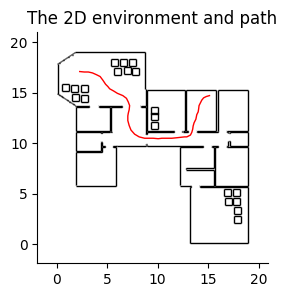

In [162]:
# ===============================
plt.figure(figsize=(3,3))
plt.title("The 2D environment and path")
ax = plt.gca()
ax.set_aspect(1)
zoom_in(_bb, 2, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plot_segs(_segs, c="k", zorder=1, ax=ax)
plot_segs(_boxes, c="k", zorder=1, ax=ax)
ax.plot(*_ps[:,:2].T, c="r", linewidth=1);

In [8]:
#|  Create a 3d mesh from the 2d data and 
#|  create a scene for the renderer
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs.reshape(-1,4))
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)
map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2]    -= 0.5

#|  Let's look at what we just created. But keep in mind that going forward 
#|  we are forgetting about the 3D structure here. This is really just
#|  so we can take advantage of the performance of the 3D renderer.
v = Viewer(width=800, cam_pos=(*(_center - jnp.array([0,25])),10), cam_look=np.array([*_center,0]), background="#eee", view_as="world")
v.add_mesh(map_mesh.vertices, map_mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(box_mesh.vertices, box_mesh.faces, c=np.array([.99,.1,.1]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))
display(v)

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

Next, we are setting up the renderer and add the *scene meshes* (the walls mesh and the box meshes).
You will see that we are rendering images of height 1 mimicing a 2d lidar sensor. The renderer not only returns a depth image but also semantic information which observation comes from which mesh (ie. from the walls or the boxes). 

In [9]:
#| Set up the renderer and add the scene mesh, i.e. add the map mesh and the box meshes.
#| Note that we are rendering an image of height 1 mimicing a 2d lidar sensor.
def make_render_function(meshes, w=100, h=1, fx=30, fy =30):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx=fx, fy=fy,
        cx=w/2 - 0.5, cy=h/2 - 0.5,
        near=0.01, far=10.0
    )
    b3d.setup_renderer(intrinsics)
    for mesh in meshes:
        b3d.RENDERER.add_mesh(mesh, center_mesh=False)


    def render(p:"3D Pose", inds=[0,1]):
        """
        Render a rendered image from a fixed scene that this is closed over.
        The image is made up off 4 channels x,y,z, and
        a "semantic layer" containing object ids.
        """
        p_ = b3d.t3d.inverse_pose(p)
        X  = b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))
        return X;

    return render


# This is the render function we are going to use 
# for the remainder of the notebooks
render = make_render_function([map_mesh, box_mesh, table]);

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 32, 1024)


The render function takes a 3D Pose consisting of a tuple of a 3D rotation matrix in $SO(3)$ and a translation vector.
But our poses `_ps` still live in 2D, so we have to *lift* them into our 3D scene.

In [10]:
def lift_pose(v, z=0.0, pitch=0.0, roll=0.0):
    """Lifts a 2d pose veoctor (x1,x2,hd) to 3d"""
    x  = v[:2]
    hd = v[ 2]
    return pack_pose(
        jnp.concatenate([x, jnp.array([z])]),
        from_euler(hd) @ CAM_ALONG_X
    ) 

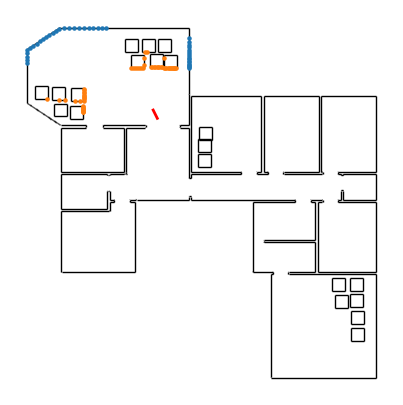

In [11]:
t  = 35
p  = _ps[t]
X  = render(lift_pose(p), inds=[0,1])
xs = X[0,:,[0,2]].T
xs = apply_2dpose(p, xs)

# NOTE: The "semantic layer" should contain ints -- it's identities after all -- 
#       but the returned `dtype` of the image is `float64`. To avoid numerical issues
#       like having entries of the form `1.9999999` and not `2` we reduce the precision 
#       a bit  
is_outlier = X[0,:,3].astype(jnp.float16) == 2

# ===========================
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.axis("off")
plot_segs(_segs, c="k", zorder=-1)
plot_segs(_boxes, c="k", zorder=-1)
plot_pose(_ps[t], ax=plt.gca())
plt.scatter(*xs[is_outlier==False].T, c="C0", s=5)
plt.scatter(*xs[is_outlier== True].T, c="C1", s=5)

In our examples we will treat the environment containing the boxes as our true **simulated world**. During inference in we optionally remove the boxes to make the localization task less trivial. That raises the necessisity to enable the model to deal with outliers.

Knowing the number of measurements that come from boxes will be helpful to interpret and tune our model. Let's write a quick helper method to do that for us.

In [163]:
def inlier_vs_outlier_counts(t):
    """Deterministic inlier (walls) and outlier (boxes) counts."""
    p  = _ps[t]
    X  = render(lift_pose(p), inds=[0,1])
    return jnp.array([
        jnp.sum(X[0,:,3].astype(jnp.float16) == 1), 
        jnp.sum(X[0,:,3].astype(jnp.float16) == 2)])

In [164]:
# Blue vs Orange counts
counts = inlier_vs_outlier_counts(40)
counts

Array([53, 47], dtype=int32)

As you see this is an example observation with a very high number (almost half) of outliers.

## Making the model

### Bayes3D Sensor Model
As in the other notebooks we need a sensor model. We are not going to write that oursleves here.

In [102]:
from genjax import tfp_uniform as uniform
from xsight.likelihood import make_constrained_sensor_model, make_baseline_sensor_model
from functools import lru_cache


def make_sensor_model(w:int, zmax:float, sensor_model_type:str="constrained"):
    """
    Returns a sensor model with given filter size `w` and maximal sensor range `zmax`.
    (The corresponding code can be found in `11 - Constrained Likelihood.ipynb`)
    """
    match sensor_model_type:
        case "constrained": return make_constrained_sensor_model(zmax, w)
        case "baseline"   : return make_baseline_sensor_model(zmax, w)
        case _: raise f"Unknown sensor model type: ``{sensor_model_type}''"

Let's "make" a sensor model and take a quick look at its signature and at its trace structure.

In [165]:
sensor_model = make_sensor_model(5, 10.)
sensor_model.source?

Signature: sensor_model.source(Y, sig, outlier)
Docstring:
Constrained sensor model that returns a vector of range measurements conditioned on 
an image, noise level, and outlier probability.
File:      ~/workspace/chi-sight/src/xsight/likelihood.py
Type:      function

In [166]:
args = Args(
    Y = render(lift_pose(_ps[40]), inds=[0,1])[:,:,:3],
    sig = 0.1,
    outlier = 0.0
)
key = keysplit(key)
tr  = sensor_model.simulate(key, args)
# ===================
# Take a look at `tr` on its own as well
display(tr.strip()) 

└── :X
    └── (Vector)
        └── :measurement
            └──  f32[100]

### Simple Localization Model

In [167]:
def make_model(w:int, zmax:float, sensor_model_type:str="constrained"):

    #  Create a sensor model
    #  Note: We need to create a closure here becasue `w` is a "static" argument
    #       and needs to be handled in a special way for GenJAX not to 
    #       complain during JIT compilation. This pattern is similar to JAX's use 
    #       of `static_argnames` in `jit`.
    sensor_model = make_sensor_model(w, zmax, sensor_model_type)

    @gen
    def model(use_boxes):
        """Isolated time-step model that optionally renders the boxes or not. """

        #  Sample a 2D pose
        #  NOTE: The x bounds are roughly bounding the environment
        #  that is baked into the renderer
        x  = uniform(jnp.array([0., 0.]), 
                     jnp.array([20., 20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi)       @ "hd"
        p  = pack_2dpose(x, hd)

        #  Sample sensor hyper parameters
        sig     = uniform(0.0, 1.) @ "sig"
        outlier = uniform(0.0, 1.) @ "outlier"

        #  Lift pose to 3D and 
        #  render an image (deterministic)
        inds = jnp.where(use_boxes, jnp.array([0,1]), jnp.array([0]))
        Y    = render(lift_pose(p), inds)

        #  Sample an image X conditioned on the rendered Y
        #  Here `inline` populates address `@ "X"`; cf. the way 
        #  the sensor model is structured. We don't have 
        #  syntactic sugar for this operation yet.
        X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 

        # NOTE: Try and replace the above line 
        # by the line below and compare the traces 
        # X, _ = sensor_model(Y[:,:,:3], sig, outlier) @ "Sensor"
        
        return p, X
    
    return model

In [168]:
# TODO: Move to imports
def plot_tr(tr, ax=None, title="", size=10, c="r", c_data="C0", boxes=None):
    
    if ax is None:
        plt.figure(figsize=(5,5))
        ax = plt.gca()

    use_boxes, = tr.args
    if boxes is not None: use_boxes = boxes
    p, X = tr.get_retval()
    xs = X[0][:,[0,2]]

    # ===============================
    if len(title) > 0: ax.set_title(f"{title}")
    ax.set_aspect(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plot_segs(_segs, c="k", zorder=1, ax=ax)
    if use_boxes: plot_segs(_boxes, c="k", zorder=1, ax=ax)
    ax.scatter(*apply_2dpose(p, xs).T, s=size, zorder=2, c=c_data)
    plot_pose(p, r=.5, zorder=3,ax=ax, c=c)

In [169]:
# NOTE: Switch the address structure in the model definition above 
# and take a look at how the trace structure changes.
w     = 0
zmax  = 10.0

model = make_model(w, zmax)
args = Args(use_boxes=True)
key = keysplit(key)

tr = model.simulate(key, args)

# ========================================
display(tr.strip())


├── :hd
│   └──  f32[]
├── :sig
│   └──  f32[]
├── :outlier
│   └──  f32[]
├── :x
│   └──  f32[2]
└── :X
    └── (Vector)
        └── :measurement
            └──  f32[100]

Re-run the cell below to get a sense for the model traces.

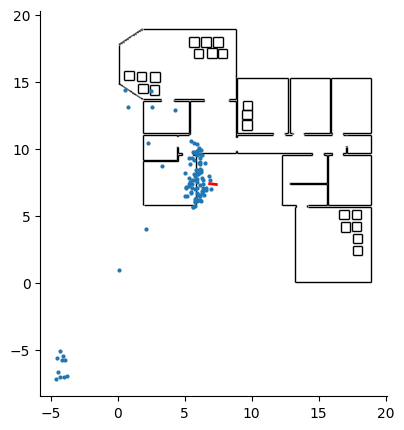

In [170]:
key  = keysplit(key)
tr   = model.simulate(key, Args(use_boxes=True))
# =========================
plot_tr(tr, size=4)

**Q:** Looking at the model is there anything that stands out to you? It is somewhat nitpicky but okay for our purposes as long as we keep that in mind.

**A:**  Note that we sample a head direction from a normal distribution. That part is fine, we just view the unit circle as the quotient `R/Z`, but if we were to evaluate a head direction under this model we would only evaluate the density at a single point, where in fact it would wrap around countably many times.

**Excercise:** Write a distribution over the unit circle by "wrapping" a normal distribution around it.

**Excercise:** Place the agent in a room with boxes. Make sure the sensor captures some of the boxes. This serves as our groundtruth. Then condition on the observation and use importance sampling to get a sense for the posterior. Do the same starting from a perturbed ground truth pose.

(Use `importance` and `importance_sampling`)

**Excercise:** Next, switch off the boxes, and note what happens to the probability scores. (Use `update` and `vmap`)


tr0.score: 68.50 
tr1.score: -172.07

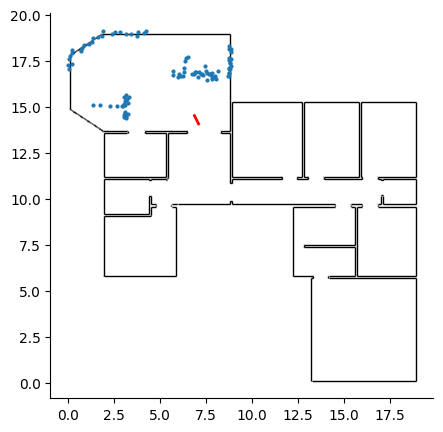

In [171]:
# NOTE: Switch `use_boxes` to `False`, and place the agent in a room with boxes. 
# Compare the scores in both cases. Play with the outlier prob and 
# incoroporate the counts computed above. What is happening, what does this imply? 

w     = 0
zmax  = 10.0
model = make_model(w, zmax)
key, keys = keysplit(key, 1, 2)

ch0 = choice_map({
        'x':  _ps[35][:2],
        'hd': _ps[35][ 2],
        'sig':     0.1,
        'outlier': 0.0 
})
w0, tr0 = model.importance(keys[0], ch0, Args(use_boxes=True))

ch1 = tr0.strip()
ch1["outlier"] = 0.5
w1, tr1 = model.importance(keys[1], ch1, Args(use_boxes=False))
# ========================================
console.print(f"""
tr0.score: {tr0.score:0.2f} 
tr1.score: {tr1.score:0.2f} 
""")
plot_tr(tr1, size=4)

In [55]:
def make_constraints(X, sensor_model_type="constrained"):
    """Return a choicemap with sensor constraints"""
    assert X.shape[-1] == 3
    
    X  = X[...,:3].reshape(-1,3)
    D  = jnp.linalg.norm(X, axis=-1)
    ch = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement":  D if sensor_model_type == "constrained" else X
            }) 
    })
    return ch

In [172]:
def get_data_logprobs(tr):
    """Return individual log-probabilities of each observed pixel value."""
    pixel_addr = lambda i: genjax.select({"X":
        genjax.index_select(i,  genjax.select("measurement"))
    })
    inds  = jnp.arange(tr["X", "measurement"].shape[0])
    logps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
    return logps

In [57]:
def _eval_pose_and_sensor(tr, key, p, sig, outlier):
    ch = choice_map({
        'x':  p[:2], 
        'hd': adjust_angle(p[2]),
        'sig':     sig,
        'outlier': outlier,
    })
    diffs = argdiffs(tr.args)
    (_, w, tr_, _) = tr.update(key, ch, diffs)
    log_ps = get_data_logprobs(tr_)
    return tr_.get_score(), log_ps


eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))
eval_pose = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, None, None)))

## Perturbing the Trace

We create a bunch of traces that could have created in a particle filter update. However we are just perturbing the ground truth pose.

In [58]:
@genjax.gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd)             @ "hd"

    q  = pack_2dpose(x, adjust_angle(hd))
    
    return q

## Create Ground Truth

In [71]:
def make_ground_truth_sampler(w=5, zmax=10.0):

    # Use the constrained model because to 
    # get perturbations along each ray.
    model = make_model(w, zmax, "constrained")

    def sampler(key, p, sig, out, use_boxes):
        args  = (use_boxes,)
        _, tr = model.importance(key, genjax.choice_map({
            "x":  p[:2],
            "hd": adjust_angle(p[2]),
            "sig":     sig, 
            "outlier": out}), args) 
        return tr

    # Jit for optimized performance
    return jit(sampler)


create_ground_truth = make_ground_truth_sampler(w=5, zmax=10.0)

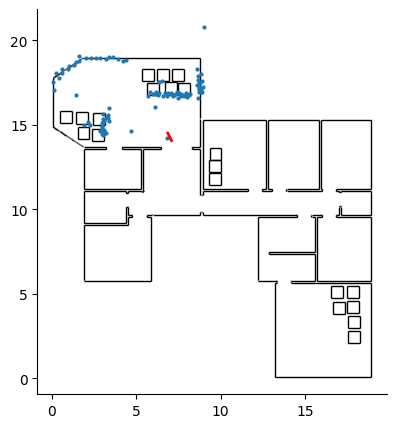

In [93]:
t0 = 35

p0        = _ps[t0]
sig0      = 1e-1
out0      = 0.1
use_boxes = True

key = keysplit(key)
tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes)
# ====================
plot_tr(tr0, size=4)

## Vector Grid

In [99]:
def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

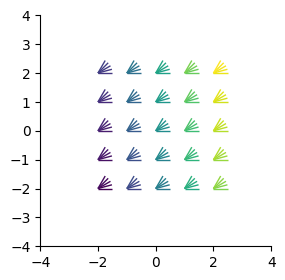

In [100]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 2, ax=ax)
plot_poses(vs, sc, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Posterior inference: Part 1
### Sensor Posterior: $\mathbb{P}(\sigma, \omega \mid p_0, X_0)$

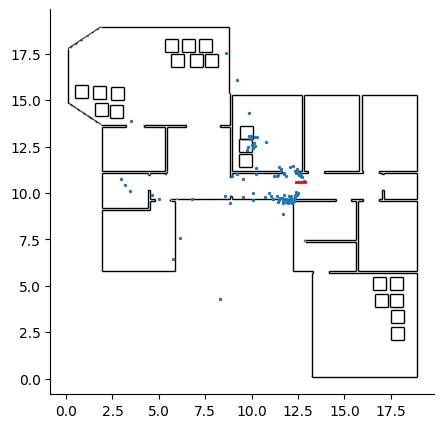

In [258]:
t0 = 15
key = keysplit(key)
p0  = _ps[t0]
sig0 = 0.2
out0 = 0.1
tr0  = create_ground_truth(key, p0, sig0, out0, use_boxes=True)
# ====================
plot_tr(tr0, size=2)

**EXCERCISE**: 

Compute and look at the posterior over sensor parameter, ie. `sig` and `outlier`, conditioned on the remaining choices from the trace above, ie. `p0` and `X0`. Use `vmap` and `jit`, and the `get_linear_grid` method from above. Assess if the model infers the right sensor parameters.


```python
def eval_sensor_posterior(tr:"Ground Truth", shape, bounds)
    assert len(shape) == len(bounds) == 2
    
    # Your code 
    # ...
        
    return grid, scores
``````

There a couple of ways to achieve this, here's our solution.

In [259]:
def _eval_sensor_posterior(key, tr, use_boxes, sig, out):
    ch = choice_map({'sig': sig, 'outlier': out})
    args = (use_boxes,)
    (_, _, tr_, _) = tr.update(key, ch, argdiffs(args))
    return tr_.get_score()


eval_sensor_posterior = jax.jit(jax.vmap(_eval_sensor_posterior, in_axes=(None, None, None, 0, 0)))

In [267]:
shape  = (20,20)
bounds = ((0.05, 1.), (1e-2, .9))
grid = get_linear_grid(shape, bounds, flat=True)
sigs  = grid[...,0]
outls = grid[...,1]
use_boxes=True

key    = keysplit(key)
scores = eval_sensor(key, tr0, use_boxes, sigs, outls)

i = jnp.argmax(scores)
console.print(f"""
MAP Inference:

    sigma:   {sigs[i]:0.2f}
    outlier: {outls[i]:0.2f}
""")

MAP Inference:

    sigma:   0.20
    outlier: 0.15

In [268]:
# TODO: Hide this cell
# TODO: move to imports
# TODO: Add coloring to the scatter plot, either by logprob or by outlier.
def sensor_posterior_experiment(key, t0, sig0, out0, use_boxes, figsize=(9,3)):

    key = keysplit(key)
    p0  = _ps[t0]
    tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes=True)

    shape = (20,20)
    grid = get_linear_grid(shape, ((0.05, 1.), (1e-2, .9)), flat=False)
    sigs = grid[...,0]
    outs = grid[...,1]

    key    = keysplit(key)
    scores = eval_sensor(key, tr0, use_boxes, sigs.ravel(), outs.ravel())


    # =================================
    fig, axs = plt.subplots(1,3, figsize=figsize, width_ratios=[1,1,1])
    plot_tr(tr0, ax=axs[0], boxes=use_boxes, size=2, c="r")


    axs[1].set_title("$\log \mathbb{P}(\sigma, \omega \mid p_0, X_0)$")
    axs[1].imshow(scores.reshape(grid.shape[:-1]), origin='lower')
    axs[1].set_ylabel("sigma")
    axs[1].set_xlabel("outlier")
    axs[1].set(
        xlabel="$\omega$ - outlier",
        xticks=[0, shape[1]-1], 
        xticklabels=[f"{v:0.2f}" for v in grid[0,[0, shape[1]-1],1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.2f}" for v in grid[[0, shape[0]-1],0,0]],
    )


    axs[2].set_title("$\mathbb{P}(\sigma, \omega \mid p_0, X_0)$")
    im = scores.reshape(grid.shape[:-1])
    im = im - logsumexp(im)
    im = jnp.exp(im)
    axs[2].imshow(im, origin='lower')
    axs[2].set_ylabel("sigma")
    axs[2].set_xlabel("outlier")
    xticks = [0, (shape[1]-1)//2,shape[1]-1]
    axs[2].set(
        xlabel="$\omega$ - outlier",
        xticks=xticks, 
        xticklabels=[f"{v:0.2f}" for v in grid[0,xticks,1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.2f}" for v in grid[[0, shape[0]-1],0,0]],
    )


    ax = axs[2]
    ax.text(1.25, 0.95, f"$\sigma = ${sig0:0.2f}\n$\omega = ${out0:0.2f}\nBoxes: {use_boxes}", transform=ax.transAxes, fontsize=11,
                        verticalalignment='top',
                        horizontalalignment='right', 
                        bbox=dict(facecolor='w', alpha=1.))
    fig.tight_layout()

### Examples with synthetic data generated by the model itself

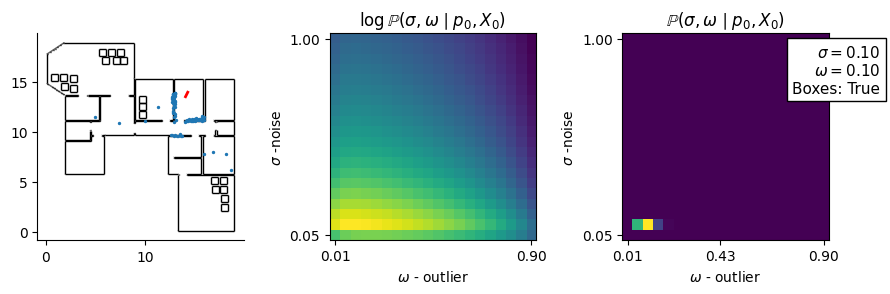

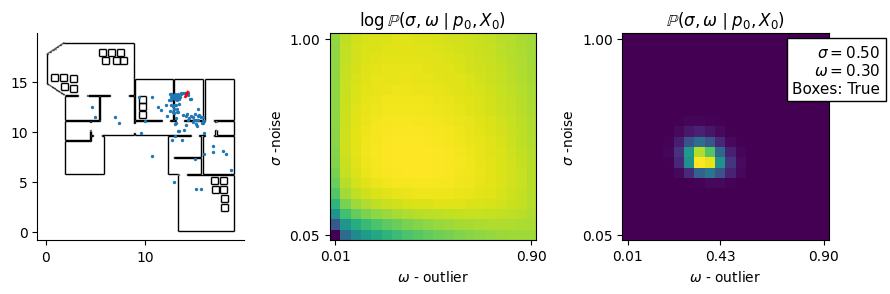

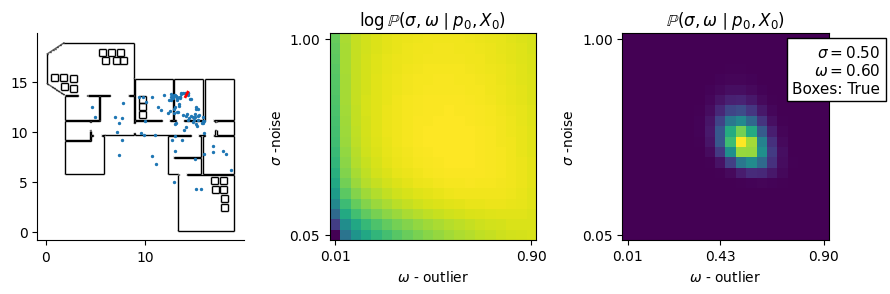

In [195]:
t0 = 4
use_boxes = True
for sig0, out0 in [(0.1,0.1),(0.5,0.3),(0.5,0.6)]:
    sensor_posterior_experiment(key, t0, sig0, out0, use_boxes)

### Examples of data that is NOT generated by the model itself. (Well it could though)

inlier vs outlier counts = [79 18], 
outlier_prob             = 0.19

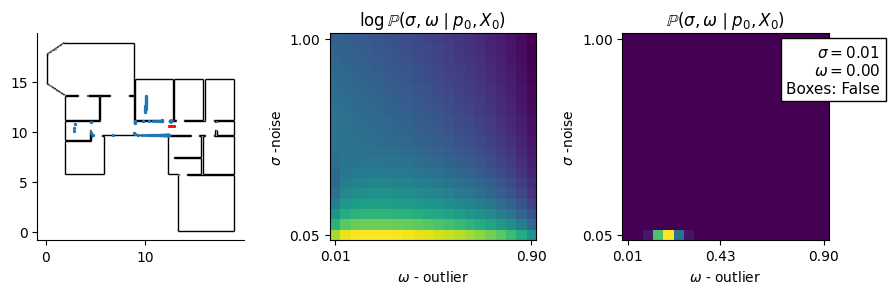

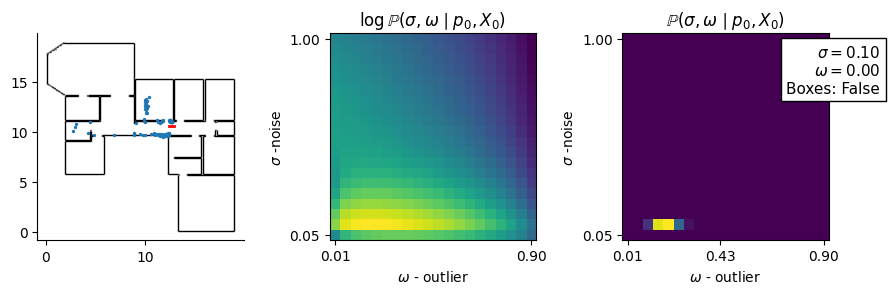

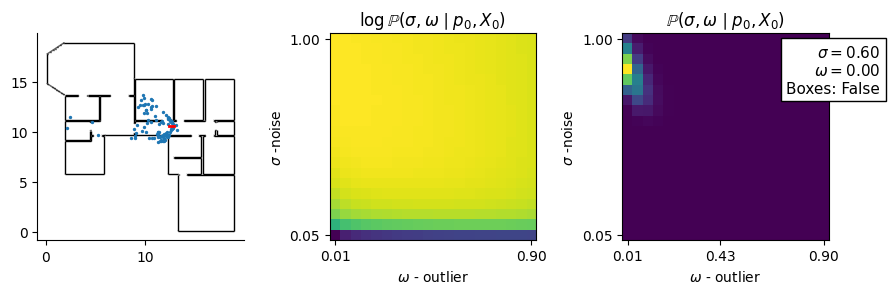

In [196]:
t0 = 15
counts = inlier_vs_outlier_counts(t0)
console.print(f"""
inlier vs outlier counts = {counts}, 
outlier_prob             = {counts[1]/jnp.sum(counts):0.2f}
""")
out0 = 0.001
use_boxes = False
for sig0 in [1e-2, 1e-1, 0.6]:
    key = keysplit(key)
    sensor_posterior_experiment(key, t0, sig0, out0, use_boxes)

### Sensor Posterior of perturbed pose:  $\mathbb{P}(\sigma, \omega \mid p, X_0)$
- What changes if we perturb the underlying pose?
- That can inform us if we are lost -> maybe question is that useful? single particle

In [42]:
def perturb_pose(key, tr, sig_x=0.1, sig_hd=5):
    keys = keysplit(key, 3)

    sig_hd = sig_hd/180*jnp.pi
    dx  = genjax.normal(jnp.array([0.0,0.0]), jnp.array([sig_x,sig_x])).sample(keys[0])
    dhd = genjax.normal(0.0, sig_hd).sample(keys[1])

    _,_,tr_,_ = tr.update(keys[2], choice_map({
        "x": tr["x"] + dx,
        "hd": tr["hd"] + dhd
    }), argdiffs(tr.args))
    
    return tr_

In [43]:
# TODO: Add coloring to the scatter plot, either by logprob or by outlier.
def sensor_posterior_experiment_2_data(key, t0, sigx, sighd, sig0, out0, use_boxes = True):


    key = keysplit(key)
    p0   = _ps[t0]
    tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes=True)

    # Perturb ground truth
    key = keysplit(key)
    tr0 = perturb_pose(key, tr0, sigx, sighd)

    key = keysplit(key)
    (_, _, tr0, _) = tr0.update(key, choice_map({}), argdiffs((use_boxes,)))

    shape = (20,20)
    grid = get_linear_grid(shape, ((0.05, 1.), (1e-2, .9)), flat=False)


    key    = keysplit(key)
    scores = eval_sensor(key, tr0, use_boxes, grid[...,0].ravel(), grid[...,1].ravel())


    I = jnp.unravel_index(jnp.argmax(scores), shape)

    return tr0, grid, scores, I
    

In [44]:
def pose_error(p, q):
    d = p - q
    d = d.at[2].set(adjust_angle(d[2]))
    return jnp.linalg.norm(d)

In [ ]:
key = keysplit(key)
t0   = 40
sig0 = 0.2
out0 = 0.01
use_boxes = False
err = []
I = []
sc = []
trs = []
for _ in range(500):
    key = keysplit(key)
    tr, grid, scores, i = sensor_posterior_experiment_2_data(key, t0, 1., 25, sig0, out0, use_boxes)
    p,_ = tr.get_retval()
    trs.append(tr)
    err.append(pose_error(p, _ps[t0]))
    I.append(i)
    sc.append(jnp.max(scores))

I = jnp.array(I)
err = jnp.array(err)
sc = jnp.array(sc)
I.shape

In [37]:
counts = inlier_vs_outlier_counts(t0)
print(f"""
inlier vs outlier counts = {counts}, 
outlier_prob             = {counts[1]/jnp.sum(counts):0.2f}
""")


inlier vs outlier counts = [53 47], 
outlier_prob             = 0.47



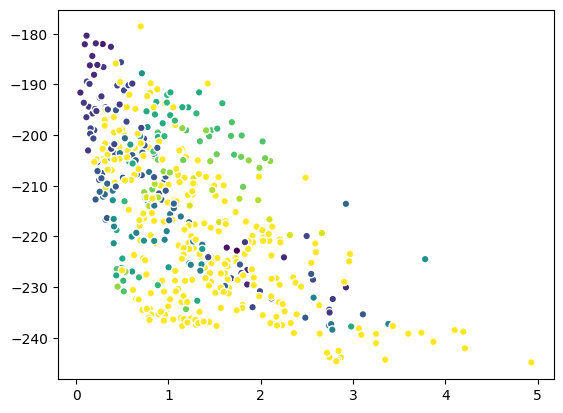

In [42]:
# plt.scatter(err, [tr.get_score() for tr in trs], c=I[:,0], s=30, edgecolor="w")
# plt.scatter(err, [tr.get_score() for tr in trs], c=sc, s=40, edgecolor="w")
plt.scatter(err, sc, c=I[:,0], s=30, edgecolor="w")
# plt.scatter(err, I[:,0], c=sc)

-inf


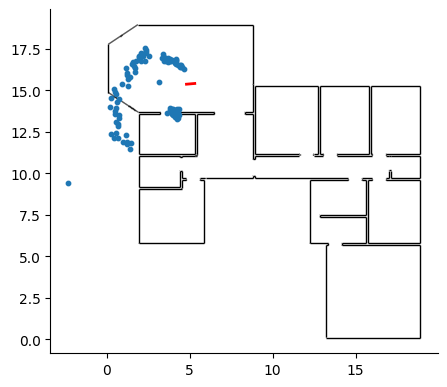

In [178]:
i = np.argsort(I[:,0])[0]
plot_tr(trs[i])
print(sc[i])

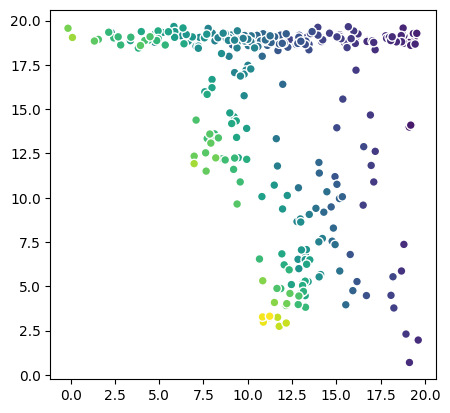

In [179]:
shape = grid.shape[:-1]
ax    = plt.gca()
ax.set_aspect(1)
I_ = I + 0.3*np.random.randn(*I.shape)

cs = sc
order = jnp.argsort(cs)

ax.scatter(I_[order,1], I_[order,0], c=cs[order], s=40, edgecolor="w", cmap="viridis")
xticks = [0, shape[1]-1]
# ax.set(
#     xlabel="$\omega$ - outlier",
#     xticks=xticks, 
#     xticklabels=[f"{v:0.2f}" for v in grid[0,xticks,1]],
#     ylabel="$\sigma$ -noise",
#     yticks=[0, shape[0]-1], 
#     yticklabels=[f"{v:0.2f}" for v in grid[[0, shape[0]-1],0,0]],
# );

In [276]:
# TODO: Add coloring to the scatter plot, either by logprob or by outlier.
def sensor_posterior_experiment_2(key, t0, sigx, sighd, sig0, out0, use_boxes = True, figsize=(9,3)):

    key = keysplit(key)
    p0   = _ps[t0]
    tr0 = create_ground_truth(key, p0, sig0, out0, jnp.array([0,1]))

    # Perturb ground truth
    key = keysplit(key)
    tr0 = perturb_pose(key, tr0, sigx, sighd)

    shape = (20,20)
    grid = get_linear_grid(shape, ((0.05, 1.), (1e-2, .9)), flat=False)


    key    = keysplit(key)
    inds = jnp.array([0,1]) if use_boxes else jnp.array([0])
    scores = eval_sensor(key, tr0, inds, grid[...,0].ravel(), grid[...,1].ravel())

    print(jnp.argmax(scores.reshape(grid.shape[:-1])))
    # =================================
    fig, axs = plt.subplots(1,3, figsize=figsize)

    plt.suptitle(f"sig={sig0:0.2f}, out={out0:0.2f}, boxes:{use_boxes}")
    plot_tr(tr0, ax=axs[0], boxes=use_boxes)
    
    axs[1].set_title("$\log \mathbb{P}(\sigma, \omega \mid p, X_0)$")
    im  = scores.reshape(grid.shape[:-1])
    axs[1].imshow(im, origin='lower')
    axs[1].set_ylabel("sigma")
    axs[1].set_xlabel("outlier")
    axs[1].set(
        xlabel="$\omega$ - outlier",
        xticks=[0, shape[1]-1], 
        xticklabels=[f"{v:0.2f}" for v in grid[0,[0, shape[1]-1],1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.4f}" for v in grid[[0, shape[0]-1],0,0]],
    )
    i0 = np.argmin(jnp.abs(grid[:, 0, 0]-sig0)) 
    i1 = np.argmin(jnp.abs(grid[0, :, 1]-out0)) 
    I = jnp.unravel_index(jnp.argmax(scores), shape)
    axs[1].scatter(i1,i0, c="r", marker="^")

    I = jnp.unravel_index(jnp.argmax(scores), shape)
    axs[1].scatter(I[1],I[0], c="b", marker="x")
    
    axs[2].set_title("$\mathbb{P}(\sigma, \omega \mid p, X_0)$")
    im = scores.reshape(grid.shape[:-1])
    im = im - logsumexp(im)
    im = jnp.exp(im)
    axs[2].imshow(im, origin='lower')
    axs[2].set_ylabel("sigma")
    axs[2].set_xlabel("outlier")
    axs[2].set(
        xlabel="$\omega$ - outlier",
        xticks=[0, shape[1]-1], 
        xticklabels=[f"{v:0.2f}" for v in grid[0,[0, shape[1]-1],1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.4f}" for v in grid[[0, shape[0]-1],0,0]],
    )
    fig.tight_layout()

399
395
194
79
399


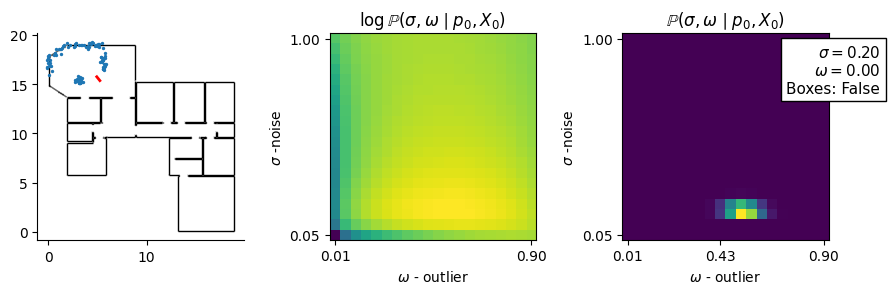

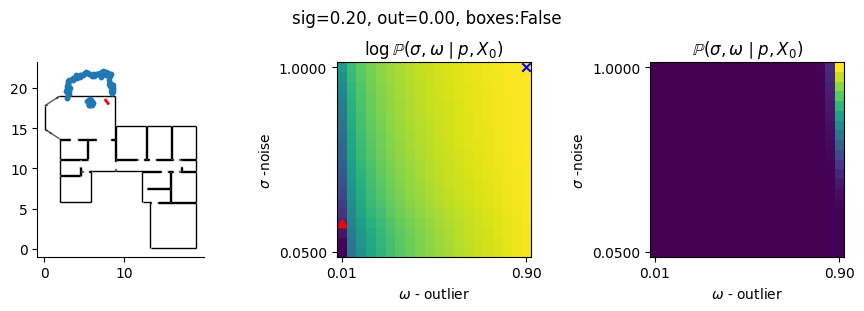

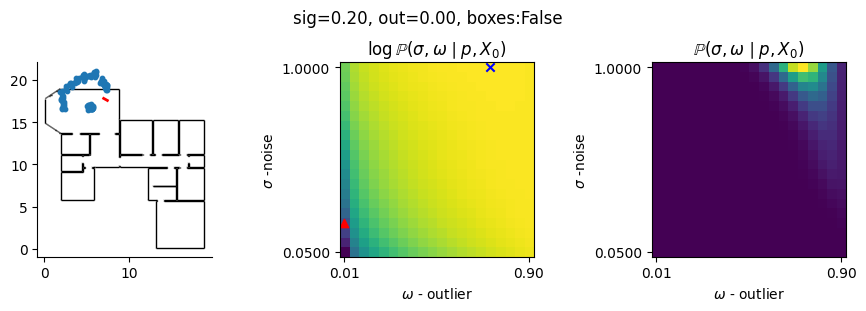

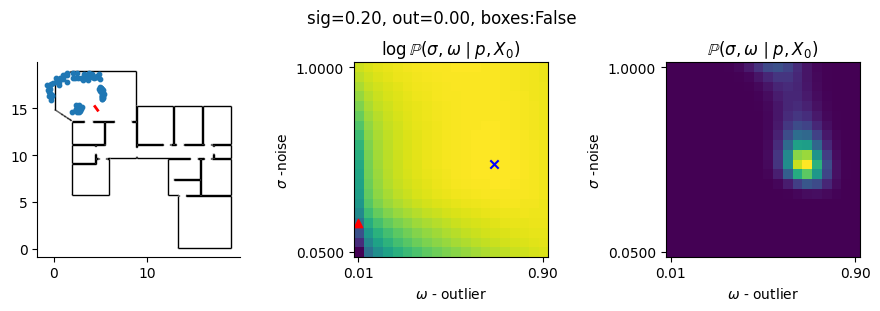

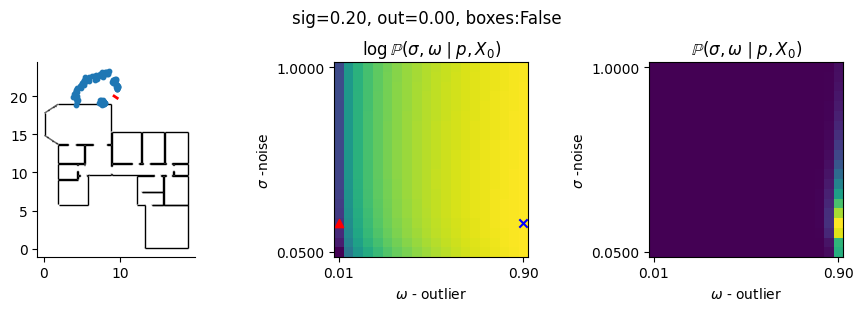

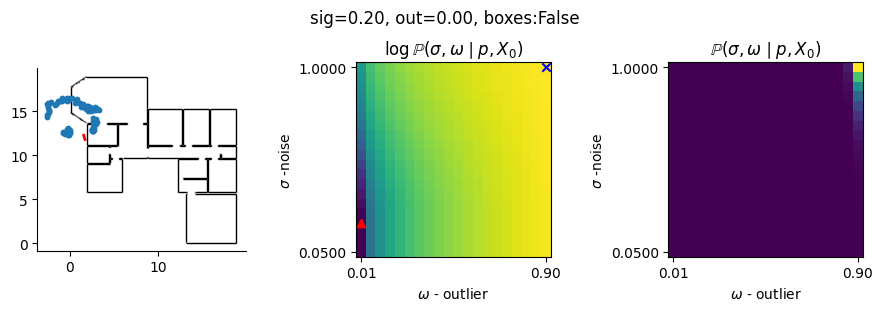

In [277]:
key = keysplit(key)
t0   = 40
sig0 = 0.2
out0 = 0.0
use_boxes = False
sensor_posterior_experiment(key, t0, sig0, out0, use_boxes)

for _ in range(5):
    key = keysplit(key)
    sensor_posterior_experiment_2(key, t0, 3., 20, sig0, out0, use_boxes, figsize=(9,3))

# Demos

## Pose Posterier: $\mathbb{P}(p \mid \sigma, \omega, X_0)$

In [32]:
# TODO: Convince me that this is actually faster.
@lru_cache(maxsize=None)
def make_inference_trace_sampler(w, zmax, sensor_model_type):
    model = make_model(w, zmax, sensor_model_type)
    importance = jit(model.importance)
    return importance

In [33]:
from timeit import timeit
from ipywidgets import (interact, interactive, IntSlider, FloatSlider, HTMLMath, HTML,
        FloatRangeSlider, RadioButtons, Checkbox, Dropdown, Button, VBox, HBox, Output)
import warnings
warnings.filterwarnings('ignore')

button = Button(
                description='Save config',
                disabled=False, button_style='', # 'success', 'info', 'warning', 'danger' or ''
                icon='check' # (FontAwesome names without the `fa-` prefix)
        )


confs = []
vs    = None
sc    = None
shape = None
logps = None
tr0   = None
X0    = None


def func(t, sig0, out0, regenerate, inference_model_type, use_boxes, num_xy, num_hd, xs, ys, hds, sig, out, show_probs, quantile, PAD):

        def on_click(button):
                global confs;
                nonlocal t, sig0, out0, sig, out, use_boxes;
                conf = dict(t=t, sig0=sig0, out0=out0, sig=sig, out=out, use_boxes=use_boxes) 
                confs.append(conf)

        button.on_click(on_click)

        global key, tr0, X0;

        p0  = _ps[t]

        # Regenerate ground truth?
        if regenerate:
                key = keysplit(key)
                tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes=True)
                _, X0  = tr0.get_retval()


        # Preparing a base trace for inference, i.e. one 
        # that we can call update on 
        w, zmax = 5, 10.0
        # %timeit -n 1 -r 1 make_inference_trace_sampler(w, zmax, inference_model_type)

        inference_model_importance = make_inference_trace_sampler(
                w, zmax, inference_model_type)

        ch            = make_constraints(X0, inference_model_type)
        ch["outlier"] = 0.1

        key = keysplit(key)
        _, tr = inference_model_importance(key, ch, (use_boxes,))


        # Create a vector grid
        shape       = (num_xy, num_xy, num_hd)
        grid_bounds = (xs + p0[0], ys + p0[1], hds + p0[2])
        vs          = get_linear_grid(shape, grid_bounds, flat=False)
        vs_flat     = vs.reshape(-1, len(shape))


        # Evaluate the Grid
        key = keysplit(key)
        # timed = timeit('eval_pose(tr, key, vs_flat[:,:3], sig, out);', globals=globals(), number=1)
        timed = timeit(lambda: eval_pose(tr, key, vs_flat[:,:3], sig, out), globals=globals(), number=1)
        key = keysplit(key)
        sc_flat, logps_flat = eval_pose(tr, key, vs_flat[:,:3], sig, out)
        sc = sc_flat.reshape(shape)
        logps = logps_flat.reshape(shape + (X0.shape[1],))

        ###############################
        ###############################
        ###############################
        ###############################
        fig, axs = plt.subplots(1,2, figsize=(12,7))

        ##
        ##  Ground Truth
        ##
        plot_tr(tr0, ax=axs[0])
        zoom_in(p0[:2], PAD, ax=axs[0])
        axs[0].set_title("Ground Truth\nfrom simulated world")


        ##
        ##  Posterior: Pose
        ##
        ax = axs[1]
        ax.text(0.05, 0.95, f"Num evals: {np.prod(shape)}\nGrid evaluation: {timed*1_000:4.2f} ms ", transform=axs[1].transAxes, fontsize=11,
                        verticalalignment='top', 
                        bbox=dict(facecolor='w', alpha=1.))

        if show_probs: ax.set_title("Posterior over poses\n$\mathbb{P}(p \mid \sigma, \omega, X_0)$")
        else: ax.set_title("Posterior over poses\n$\log \mathbb{P}(p \mid \sigma, \omega, X_0)$")
        ax.set_aspect(1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        zoom_in(p0[:2], PAD, ax=ax)
        plot_segs(_segs, c="k", zorder=1,ax=ax)
        if use_boxes: plot_segs(_boxes, c="k", zorder=1,ax=ax)

        sc_ = sc - logsumexp(sc)
        if show_probs: plot_poses(vs, jnp.exp(sc_), r=0.5, q=quantile, clip=-1e12, ax=ax)
        else: plot_poses(vs, sc_, r=0.5, q=quantile, clip=-1e12, ax=ax)

        fig.tight_layout()


widget = interactive(func,
        t = IntSlider(min=0, max=_T-1, step=1, value=35, continuous_update=False, description="Pose"),
        sig0 = FloatSlider(min=1e-6, max=1., step=0.01, value=1e-6, continuous_update=False, description='sigma'),
        out0 = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False, description='outlier'),
        regenerate  = Checkbox(value=True, description='Regenerate:',disabled=False),
        inference_model_type = Dropdown(options=["constrained", "baseline"],value="constrained",description='Model',disabled=False),
        use_boxes            = Checkbox(value=True, disabled=False, description='Use Boxes'),
        num_xy  = IntSlider(min=0, max=30, step=1, value=5, continuous_update=False, description='x, y'),
        num_hd  = IntSlider(min=0, max=30, step=1, value=5, continuous_update=False, description='hd'),
        xs   = FloatRangeSlider(min=-8.0, max=8.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False, description='x'),
        ys   = FloatRangeSlider(min=-8.0, max=8.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False, description='y'),
        hds  = FloatRangeSlider(min=-jnp.pi, max=jnp.pi, step=0.01, value=[-jnp.pi/4,jnp.pi/4], readout_format='.1f', continuous_update=False, description='hd'),
        sig  = FloatSlider(min=0.05, max=1., step=0.01, value=0.1, continuous_update=False, description='sigma'),
        out  = FloatSlider(min=0.0, max=1., step=0.01, value=0.1, continuous_update=False, description='outlier'),
        show_probs = Checkbox(value=False, disabled=False, description='Probability'),
        quantile = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False),
        PAD = FloatSlider(min=0.0, max=15., step=0.01, value=8.0, continuous_update=False),
)

ground_truth_children = widget.children[:4]
options_children      = widget.children[4:6]
grid_shape_children   = widget.children[6:8]
grid_entries_children = widget.children[8:13]
plot_children         = widget.children[13:16]

interactive_full_posterior = VBox([  
        HTML("<h1>Pose Posterior Explorer</h1>"),
        HBox([
                VBox([HTML("<h2>Ground Truth</h2>"), *ground_truth_children]),
                VBox([HTML("<h2>Plotting</h2>"), *plot_children]),
        ]),
        HBox([HTML("<h2>Grid Inference</h2>")]),
        HBox([*reversed(options_children)]),
        HBox([  
                VBox([HTML("<b>Grid Shape</b>"), *grid_shape_children]),
                VBox([HTML("<b>Grid Values</b>"), *grid_entries_children]),
        ]),
        widget.children[-1]
])  

interactive_full_posterior

## Full posterior: $\mathbb{P}(p, \sigma, \omega \mid X_0)$

In [40]:
from timeit import timeit
from ipywidgets import (interact, interactive, IntSlider, FloatSlider, Label, HTML,
        FloatRangeSlider, RadioButtons, Checkbox, Dropdown, Button, VBox, HBox, Output)
import warnings
warnings.filterwarnings('ignore')

button = Button(
                description='Save config',
                disabled=False, button_style='', # 'success', 'info', 'warning', 'danger' or ''
                icon='check' # (FontAwesome names without the `fa-` prefix)
        )

confs = []
vs    = None
sc    = None
shape = None
logps = None
tr0   = None
X0    = None


def func(t, sig0, out0, regenerate, inference_model_type, use_boxes, num_xy, num_hd, num_sig, num_out, xs, ys, hds, sigs, outs,  show_probs, quantile, PAD):

        global key, tr0, X0;

        p0  = _ps[t]

        # Regenerate ground truth?
        if regenerate:
                key = keysplit(key)
                tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes=True)
                _, X0  = tr0.get_retval()


        # Preparing a base trace for inference, i.e. one 
        # that we can call update on 
        w, zmax = 5, 10.0
        # %timeit -n 1 -r 1 make_inference_trace_sampler(w, zmax, inference_model_type)

        inference_model_importance = make_inference_trace_sampler(
                w, zmax, inference_model_type)


        ch            = make_constraints(X0, inference_model_type)
        ch["outlier"] = 0.1

        key = keysplit(key)
        _, tr = inference_model_importance(key, ch, (use_boxes,))


        # Create a vector grid
        shape       = (num_xy, num_xy, num_hd, num_sig, num_out)
        grid_bounds = (xs + p0[0], ys + p0[1], hds + p0[2], sigs, outs)
        vs          = get_linear_grid(shape, grid_bounds, flat=False)
        vs_flat     = vs.reshape(-1, len(shape))


        # Evaluate the Grid
        key = keysplit(key)
        timed = timeit(lambda: eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4]), globals=globals(), number=1)
        key = keysplit(key)
        sc_flat, logps_flat = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4])
        sc = sc_flat.reshape(shape)
        logps = logps_flat.reshape(shape + (X0.shape[1],))


                
        sensor_marginal = logsumexp(sc, axis=(0,1,2))
        sensor_marginal = sensor_marginal - logsumexp(sensor_marginal)


        pose_marginal = logsumexp(sc, axis=(3,4))
        pose_marginal = pose_marginal - logsumexp(pose_marginal)

        ###############################
        ###############################
        ###############################
        fig, axs = plt.subplots(2,3, figsize=(12,8), height_ratios=[1,15], width_ratios=[5,5,2])
        for ax in axs[0,:]: ax.axis("off")

        ##
        ##  TEXT
        ##
        ax = axs[0,0]
        ax.text(0.05, 0.05, f"Num evals: {np.prod(shape)}\nGrid evaluation: {timed*1_000:4.2f} ms ", transform=ax.transAxes, fontsize=11,
                        verticalalignment='top', 
                        bbox=dict(facecolor='w', alpha=1.))

        ##
        ##  Ground Truth
        ##
        ax = axs[1,0]
        ax.set_title("Ground Truth\nfrom simulated world")
        plot_tr(tr0, ax=ax)
        zoom_in(p0[:2], PAD, ax=ax)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        

        ##
        ##  Marginal: Sensor Params
        ##
        ax = axs[1,2]
        if show_probs: ax.set_title("Marginalized posterior\nover sensor parameters\n$\mathbb{P}(\sigma, \omega \mid X_0)$")
        else: ax.set_title("Marginalized posterior\nover sensor parameters\n$\log \mathbb{P}(\sigma, \omega \mid X_0)$")
        ax.set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                ylabel="noise",
                yticks=[0, shape[3]-1], 
                yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
        )
        if show_probs: ax.imshow(jnp.exp(sensor_marginal), origin="lower")
        else: ax.imshow(sensor_marginal, origin="lower")

        ##
        ##  Marginal: Pose
        ##
        ax = axs[1,1]
        if show_probs: ax.set_title("Marginalized posterior\nover poses $\mathbb{P}(p \mid X_0)$")
        else: ax.set_title("Marginalized posterior\nover poses $\log \mathbb{P}(p \mid X_0)$")
        ax.set_aspect(1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        zoom_in(p0[:2], PAD, ax=ax)
        plot_segs(_segs, c="k", zorder=1, ax=ax)
        if use_boxes: plot_segs(_boxes, c="k", zorder=1, ax=ax)
        if show_probs: plot_poses(vs[:,:,:,0,0,:3], jnp.exp(pose_marginal), r=0.5, q=quantile, clip=-1e12, ax=ax)
        else: plot_poses(vs[:,:,:,0,0,:3], pose_marginal, r=0.5, q=quantile, clip=-1e12, ax=ax)

        fig.tight_layout()



widget = interactive(func,
        t    = IntSlider(min=0, max=_T-1, step=1, value=35, continuous_update=False, description="Pose"),
        sig0 = FloatSlider(min=1e-6, max=1., step=0.01, value=1e-6, continuous_update=False, description="Noise"),
        out0 = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False,   description="Outlier"),
        regenerate  = Checkbox(value=True, description='Regenerate',disabled=False),
        inference_model_type = Dropdown(options=["constrained", "baseline"], value="constrained", description='Model',disabled=False),
        use_boxes            = Checkbox(value=True,description='Use Boxes',disabled=False),
        num_xy  = IntSlider(min=1, max=10, step=1, value=5, continuous_update=False, description="x, y"),
        num_hd  = IntSlider(min=1, max=10, step=1, value=5, continuous_update=False, description="hd"),
        num_sig = IntSlider(min=1, max=10, step=1, value=5, continuous_update=False, description="sigma"),
        num_out = IntSlider(min=1, max=10, step=1, value=5, continuous_update=False, description="outlier"),
        xs   = FloatRangeSlider(min=-3.0, max=3.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False, description="x"),
        ys   = FloatRangeSlider(min=-3.0, max=3.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False, description="y"),
        hds  = FloatRangeSlider(min=-jnp.pi, max=jnp.pi, step=0.01, value=[-jnp.pi/4,jnp.pi/4], readout_format='.1f', continuous_update=False, description="hd"),
        sigs = FloatRangeSlider(min=1e-6, max=1.0, step=0.01, value=[0.01,0.7], readout_format='.1f', continuous_update=False, description="sigma"),
        outs = FloatRangeSlider(min=0.0,  max=1.0, step=0.01, value=[0.01,0.9], readout_format='.1f', continuous_update=False, description="outlier"),
        show_probs = Checkbox(value=False, description='Probability',disabled=False),
        quantile   = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False, description="Quantile"),
        PAD        = FloatSlider(min=0.0, max=15., step=0.01, value=8.0, continuous_update=False, description="Zoom"),
)


ground_truth_children = widget.children[:4]
options_children      = widget.children[4:6]
grid_shape_children   = widget.children[6:10]
grid_entries_children = widget.children[10:15]
plot_children         = widget.children[15:18]

interactive_full_posterior = VBox([  
        HTML("<h1>Full Posterior Explorer</h1>"),
        HBox([
                VBox([HTML("<h2>Ground Truth</h2>"), *ground_truth_children]),
                VBox([HTML("<h2>Plotting</h2>"), *plot_children]),
        ]),
        HBox([HTML("<h2>Grid Inference</h2>")]),
        HBox([*reversed(options_children)]),
        HBox([  
                VBox([HTML("<b>Grid Shape</b>"), *grid_shape_children]),
                VBox([HTML("<b>Grid Values</b>"), *grid_entries_children]),
        ]),
        widget.children[-1]
])  

interactive_full_posterior

**Q:** What are ways to "constrain" a model to a particular noise level?
- Clamp the respective choice in the choice map.
- Use a different prior over the noise level.

**Q:** How do we encode a preference for lower noise levels/ Tell the model to prefer lower noiselevels.

**Q:** Do you think that makes sense for outliers as well? Why? Why not?

## Animation

In [352]:
regenerate = True
inference_model_type = "constrained"
use_boxes = False
t = 35
PAD = 1
quantile=0.5

p0  = _ps[t]

sig0=0.1
out0=0.0

# Regenerate ground truth?
if regenerate:
    key = keysplit(key)
    tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes=True)
    _, X0  = tr0.get_retval()


# Preparing a base trace for inference, i.e. one 
# that we can call update on 
w, zmax = 5, 10.0
# %timeit -n 1 -r 1 make_inference_trace_sampler(w, zmax, inference_model_type)

inference_model_importance = make_inference_trace_sampler(
        w, zmax, inference_model_type)


ch            = make_constraints(X0, inference_model_type)
ch["outlier"] = 0.1

key = keysplit(key)
_, tr = inference_model_importance(key, ch, (use_boxes,))

72.04 ms

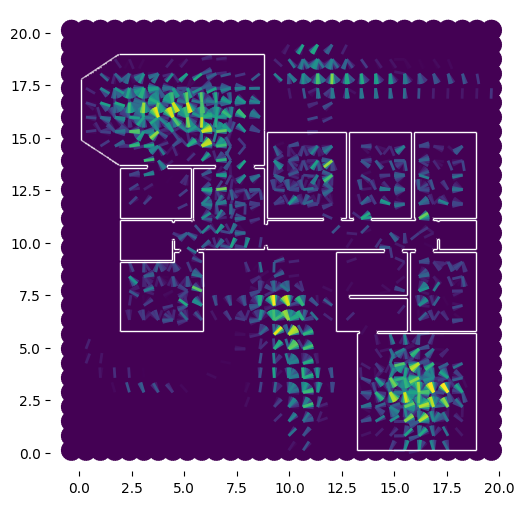

In [354]:



num_xy = 30
num_hd = 30
num_sig = 1
num_out = 1


xs  = jnp.array([0,20]) + 0.5*(np.random.rand() - 0.5)*2
ys  = jnp.array([0,20]) + 0.5*(np.random.rand() - 0.5)*2
hds = jnp.array([-jnp.pi, jnp.pi]) + 5/180*jnp.pi*(np.random.rand() - 0.5)*2

sigs = jnp.array([0.4,0.4])
outs = jnp.array([0.1,0.1])

# Create a vector grid
shape       = (num_xy, num_xy, num_hd, num_sig, num_out)
grid_bounds = (xs, ys, hds, sigs, outs)
vs          = get_linear_grid(shape, grid_bounds, flat=False)
vs_flat     = vs.reshape(-1, len(shape))
N = np.prod(shape)
N

timed = timeit(lambda: get_linear_grid(shape, grid_bounds, flat=False), globals=globals(), number=1)

# Evaluate the Grid
key = keysplit(key)
timed += timeit(lambda: eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4]), globals=globals(), number=1)
key = keysplit(key)
sc_flat, logps_flat = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4])
sc = sc_flat.reshape(shape)
logps = logps_flat.reshape(shape + (X0.shape[1],))


sensor_marginal = logsumexp(sc, axis=(0,1,2))
sensor_marginal = sensor_marginal - logsumexp(sensor_marginal)

tau = 6.
pose_marginal = 1/tau*logsumexp(sc, axis=(3,4))
pose_marginal = pose_marginal - logsumexp(pose_marginal)


console.print(f"{timed*1000:0.2f} ms")

plt.figure(figsize=(6,6))
ax = plt.gca()

ax.set_aspect(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
zoom_in(vs_flat[:,:2], PAD, ax=ax)
plot_segs(_segs, c="w", zorder=1, ax=ax)
if use_boxes: plot_segs(_boxes, c="w", zorder=1, ax=ax)
# plot_poses(vs[:,:,:,0,0,:3], jnp.exp(pose_marginal), r=0.5, q=0.9, clip=-1e12, ax=ax)
plot_poses(vs[:,:,:,0,0,:3], pose_marginal, r=0.5, q=0.9, clip=-1e12, ax=ax)

In [346]:
proposal = jit(vmap(lambda key, ws: genjax.categorical(ws.ravel()).sample(key), (0, None)))

1.454886510000506 ms

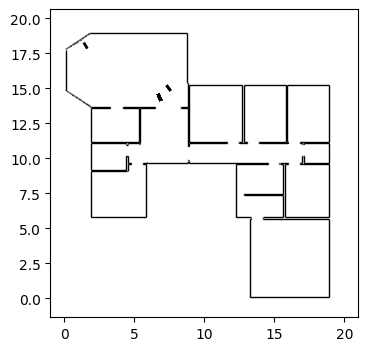

In [347]:
key = keysplit(key)

timed2 = timeit(lambda: proposal(keysplit(key, 500), pose_marginal), number=1)
I = proposal(keysplit(key, 100), pose_marginal)
ps  = np.array(vs_flat[I,:3])
ps[:,:2] += 0.*np.random.randn(len(ps), 2)
ps[:,2] += 0/180*np.pi*np.random.randn(len(ps))
plt.figure(figsize=(4,4))
ax = plt.gca()
zoom_in(vs_flat[:,:2], PAD, ax=ax)
plot_segs(_segs, c="k", zorder=1, ax=ax)
plot_poses(ps, c="k")

console.print(f"{timed2*1000/len(ps)} ms")

In [348]:
tail = 20
ps = jnp.concatenate([ps, ps[:tail]], axis=0)
ps.shape

(120, 3)

In [349]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image

cm  = getattr(plt.cm,  "bwr")
# vs_ = np.clip(vs, v_min, v_max)
# cs  = cm(plt.Normalize()(vs_))


# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
# for t in range(30):

for t in range(tail,len(ps)):

    cs = np.zeros(len(ps))
    t0 = max(t-tail,0)
    t1 = t
    cs[t0:t1] = np.linspace(tail -(t1-t0), tail, t1-t0)/tail
    c_vals = cs
    cs = cs**2
    order = np.argsort(cs)
    # cs = rgba_from_vals(cs/2 + 0.5, cmap="bwr", vmin=0.0, vmax=1.)
    cs = cm(cs/2 + 0.5)
    
    fig  = plt.figure(figsize=(4,4))
    ax = plt.gca()
    ax.set_aspect(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    zoom_in(_bb, 2, ax=ax)
    plot_segs(_segs, c="k", zorder=2, linewidth=1, ax=ax)
    # lw = (1-c_vals[order][tail:])*8
    lw = 1
    plot_poses(ps[order][tail:], cs=cs[order][tail:],  r=1.0, linewidth=lw, zorder=1)

    canvas = FigureCanvas(fig)
    canvas.draw()


    # im = np.frombuffer(fig.canvas.renderer.tostring_rgb(), dtype=np.uint8)
    # ratio = fig.get_figheight()/fig.get_figwidth()
    # im = im.reshape(fig.get_figheight(), fig.get_figwidth(), 3)
    im = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    ims.append(im)


    plt.close()


# ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
#                                 repeat_delay=1000)

# # To save the animation, use e.g.
# #
# # ani.save("movie.mp4")
# #
# # or
# #
# # writer = animation.FFMpegWriter(
# #     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# # ani.save("movie.mp4", writer=writer)

# ani


# from PIL import Image
# def make_gif(frame_folder):
#     frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.JPG")]
#     frame_one = frames[0]
#     frame_one.save("my_awesome.gif", format="GIF", append_images=frames,
#                save_all=True, duration=100, loop=0)


ims[0].save("_my_awesome.gif", format="GIF", append_images=ims[1:],
            save_all=True, duration=60, loop=0)

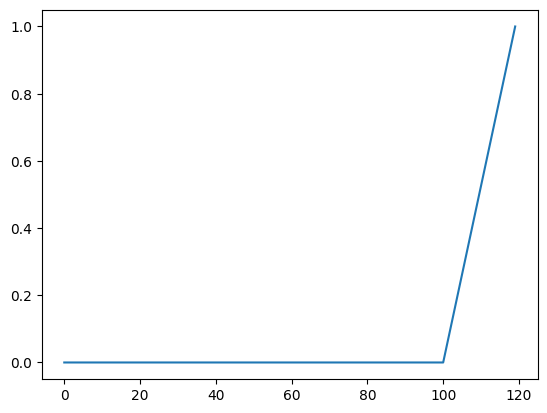

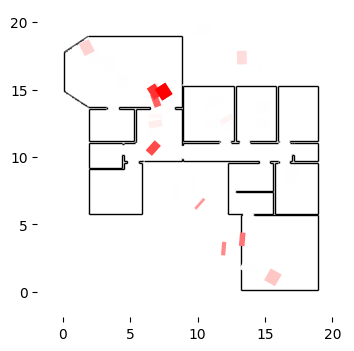

In [336]:
plt.plot(c_vals[order])

fig  = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.set_aspect(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

zoom_in(_bb, 2, ax=ax)
plot_segs(_segs, c="k", zorder=1, linewidth=1, ax=ax)
plot_poses(ps[order][tail:], cs=cs[order][tail:],  r=1.0, linewidth=np.arange(10), zorder=2)


[<matplotlib.lines.Line2D object at 0x7fa4c176ff40>]

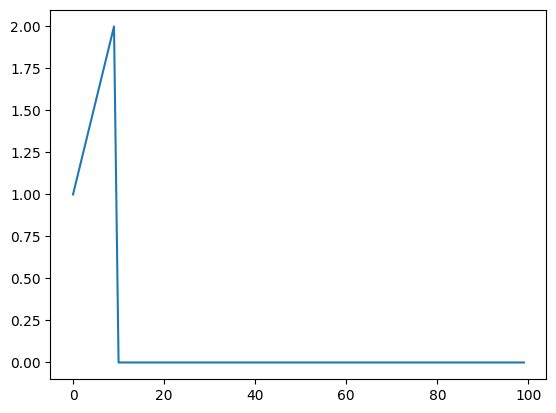

In [220]:
t = 10
tail = 20
cs = np.zeros(100)
t0 = max(t-tail,0)
t1 = t
cs[t0:t1] = np.linspace(tail -(t1-t0), tail, t1-t0)/t1
plt.plot(cs)

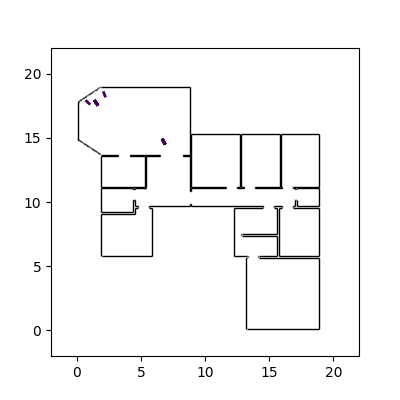

In [204]:
ims[2]

# Appendix

In [ ]:
# TODO: Alternative version of the above model. Add excercise to change above model into this.
#       After looking at posterior over large area and realizing that it works reliably locally....
def make_anchored_model(w:int, zmax:float, sensor_model_type:str="constrained"):

    # Create a sensor model
    sensor_model = make_sensor_model(w, zmax, sensor_model_type)

    @gen
    def model(p:"Pose", sig:float, outlier:float, use_boxes=True):

        x  = diagnormal(p[:2], 0.5)      @ "x"
        hd = normal(p[2], 10/180*jnp.pi) @ "hd"
        p = pack_2dpose(x, hd)
        
        # Lift pose to 3D and 
        # render an image (deterministically)
        inds = jnp.where(use_boxes, jnp.array([0,1]), jnp.array([0]))
        Y    = render(lift_pose(p), inds)

        # Sample an image X conditioned on the rendered Y
        X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 

        return p, X
    
    return model